## 유튜브 영상 참고

In [1]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

#### 각도 탐지 함수

In [2]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

#### 여러 각도 확인

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

In [3]:
cap = cv2.VideoCapture(0)
## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            l_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            r_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            
            l_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            r_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            
            l_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            r_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            
            l_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
            r_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
            
            # l_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT.value].x,landmarks[mp_pose.PoseLandmark.LEFT_FOOT.value].y]
            # r_foot = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_FOOT.value].y]

            # l_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HEEL.value].y]
            # r_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HEEL.value].y]
            
            # Calculate angle
            left_angle = calculate_angle(l_hip, l_knee, l_ankle)
            right_angle = calculate_angle(r_hip, r_knee, r_ankle)
            l_knee_loc = calculate_angle(r_shoulder, l_shoulder, l_knee)
            r_knee_loc = calculate_angle(l_shoulder, r_shoulder, r_knee)

            # Visualize angle
            cv2.putText(image, str(int(left_angle)), 
                        tuple(np.multiply(l_knee, [640, 480]).astype(int)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                        )
            cv2.putText(image, str(int(right_angle)), 
                        tuple(np.multiply(r_knee, [640, 480]).astype(int)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                        )
            cv2.putText(image, str(int(l_knee_loc)), 
                        tuple(np.multiply(l_shoulder, [640, 480]).astype(int)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                        )
            cv2.putText(image, str(int(r_knee_loc)), 
                        tuple(np.multiply(r_shoulder, [640, 480]).astype(int)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                        )
        except:
            pass
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

## 경미님 코드 활용

### 평균 각도 데이터 제작

In [ ]:
import pandas as pd
import numpy as np
import glob

# 각도 계산 함수
def calculate_angle(point_a, point_b, point_c):
    vector_ab = np.array(point_a) - np.array(point_b)
    vector_cb = np.array(point_c) - np.array(point_b)
    dot_product = np.dot(vector_ab, vector_cb)
    magnitude_ab = np.linalg.norm(vector_ab)
    magnitude_cb = np.linalg.norm(vector_cb)
    if magnitude_ab == 0 or magnitude_cb == 0:
        return None
    cosine_angle = dot_product / (magnitude_ab * magnitude_cb)
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    return np.degrees(np.arccos(cosine_angle))

# 여러 CSV 파일 읽기
file_pattern = "lunge_csv_data/lunge_*.csv"  # 파일 경로 및 패턴 지정
files = glob.glob(file_pattern)

# 모든 데이터를 병합
all_data = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

# 관절 ID 매핑
LEFT_HIP = 23
LEFT_KNEE = 25
LEFT_ANKLE = 27
RIGHT_HIP = 24
RIGHT_KNEE = 26
RIGHT_ANKLE = 28

# 프레임별로 각도 계산
angles = []

for frame_number in all_data['frame'].unique():
    frame_data = all_data[all_data['frame'] == frame_number]

    try:
        # 왼쪽 관절 좌표
        left_hip = frame_data[frame_data['node_id'] == LEFT_HIP][['x', 'y', 'z']].values[0]
        left_knee = frame_data[frame_data['node_id'] == LEFT_KNEE][['x', 'y', 'z']].values[0]
        left_ankle = frame_data[frame_data['node_id'] == LEFT_ANKLE][['x', 'y', 'z']].values[0]

        # 오른쪽 관절 좌표
        right_hip = frame_data[frame_data['node_id'] == RIGHT_HIP][['x', 'y', 'z']].values[0]
        right_knee = frame_data[frame_data['node_id'] == RIGHT_KNEE][['x', 'y', 'z']].values[0]
        right_ankle = frame_data[frame_data['node_id'] == RIGHT_ANKLE][['x', 'y', 'z']].values[0]

        # 각도 계산
        left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
        right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)

        left_hip_angle = calculate_angle(left_knee, left_hip, right_hip)
        right_hip_angle = calculate_angle(right_knee, right_hip, left_hip)

        # 각도 저장
        angles.append({
            'frame': frame_number,
            'left_knee_angle': left_knee_angle,
            'right_knee_angle': right_knee_angle,
            'left_hip_angle': left_hip_angle,
            'right_hip_angle': right_hip_angle
        })

    except Exception as e:
        print(f"Frame {frame_number}: 오류 발생 - {e}")

# 결과를 DataFrame으로 변환
angle_data = pd.DataFrame(angles)

# 평균 각도 계산
knee_mean_angle = (angle_data['left_knee_angle'].mean() + angle_data['right_knee_angle'].mean()) / 2
hip_mean_angle = (angle_data['left_hip_angle'].mean() + angle_data['right_hip_angle'].mean()) / 2

# 결과 출력
print(f"무릎 평균 각도: {knee_mean_angle:.2f}°")
print(f"엉덩이 평균 각도: {hip_mean_angle:.2f}°")


무릎 평균 각도: 128.99°
엉덩이 평균 각도: 100.77°


- 무릎 평균 각도가 생각보다 큰데? => 서있던 자세도 프레임에 존재 하기때문에 평균 값이 큼
- 이걸 해결하는 계산 법이 있나 내일 한번 확인!!

In [11]:
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
import glob

# 각도 계산 함수
def calculate_angle(point_a, point_b, point_c):
    vector_ab = np.array(point_a) - np.array(point_b)
    vector_cb = np.array(point_c) - np.array(point_b)
    dot_product = np.dot(vector_ab, vector_cb)
    magnitude_ab = np.linalg.norm(vector_ab)
    magnitude_cb = np.linalg.norm(vector_cb)
    if magnitude_ab == 0 or magnitude_cb == 0:
        return None
    cosine_angle = dot_product / (magnitude_ab * magnitude_cb)
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    angle = np.degrees(np.arccos(cosine_angle))
    return angle

# 여러 CSV 파일 읽기
file_pattern = "lunge_csv_data/lunge_*.csv"
files = glob.glob(file_pattern)
all_data = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

# 관절 ID 매핑
LEFT_HIP = 23
LEFT_KNEE = 25
LEFT_ANKLE = 27
RIGHT_HIP = 24
RIGHT_KNEE = 26
RIGHT_ANKLE = 28

# 프레임별로 각도 계산
angles = []
for frame_number in all_data['frame'].unique():
    frame_data = all_data[all_data['frame'] == frame_number]

    try:
        # 왼쪽 관절 좌표
        left_hip = frame_data[frame_data['node_id'] == LEFT_HIP][['x', 'y', 'z']].values[0]
        left_knee = frame_data[frame_data['node_id'] == LEFT_KNEE][['x', 'y', 'z']].values[0]
        left_ankle = frame_data[frame_data['node_id'] == LEFT_ANKLE][['x', 'y', 'z']].values[0]

        # 오른쪽 관절 좌표
        right_hip = frame_data[frame_data['node_id'] == RIGHT_HIP][['x', 'y', 'z']].values[0]
        right_knee = frame_data[frame_data['node_id'] == RIGHT_KNEE][['x', 'y', 'z']].values[0]
        right_ankle = frame_data[frame_data['node_id'] == RIGHT_ANKLE][['x', 'y', 'z']].values[0]

        # 각도 계산
        left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
        right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)

        left_hip_angle = calculate_angle(left_knee, left_hip, right_hip)
        right_hip_angle = calculate_angle(right_knee, right_hip, left_hip)

        # 각도 저장
        angles.append({
            'frame': frame_number,
            'left_knee_angle': left_knee_angle,
            'right_knee_angle': right_knee_angle,
            'left_hip_angle': left_hip_angle,
            'right_hip_angle': right_hip_angle
        })

    except Exception as e:
        print(f"Frame {frame_number}: 오류 발생 - {e}")

# 결과를 DataFrame으로 변환
angle_data = pd.DataFrame(angles)


# 평균 각도 계산
knee_mean_angle1 = (angle_data['left_knee_angle'].mean() + angle_data['right_knee_angle'].mean()) / 2
hip_mean_angle1 = (angle_data['left_hip_angle'].mean() + angle_data['right_hip_angle'].mean()) / 2

# 최빈값 각도
knee_mean_angle2 = (angle_data['left_knee_angle'].mode() + angle_data['right_knee_angle'].mode()) / 2
hip_mean_angle2 = (angle_data['left_hip_angle'].mode() + angle_data['right_hip_angle'].mode()) / 2

# 최빈값 각도
knee_mean_angle3 = (angle_data['left_knee_angle'].median() + angle_data['right_knee_angle'].median()) / 2
hip_mean_angle3 = (angle_data['left_hip_angle'].median() + angle_data['right_hip_angle'].median()) / 2

print(knee_mean_angle)
print(hip_mean_angle)

144.00902702794593
100.29655796831287


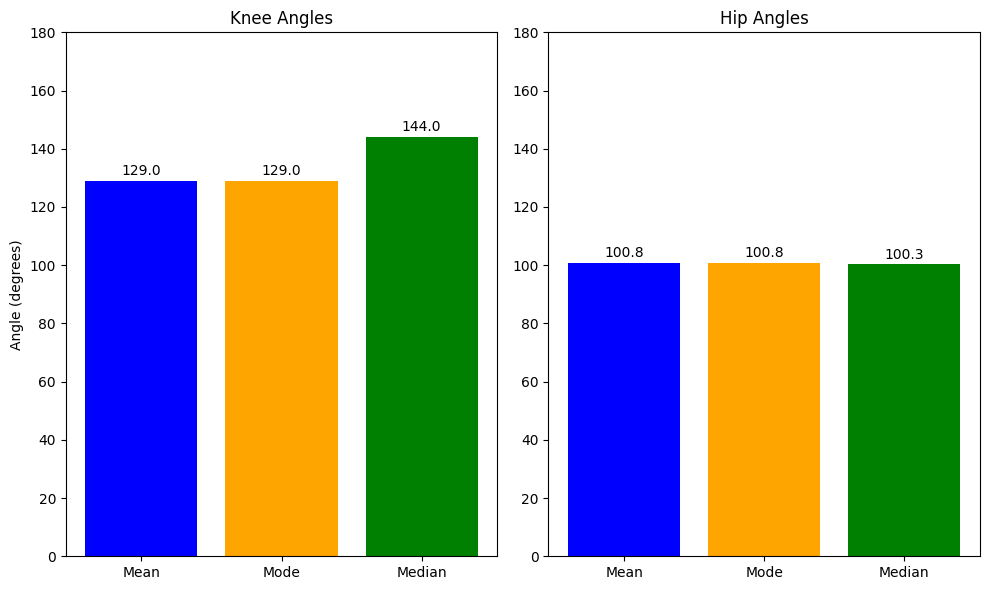

In [12]:
import matplotlib.pyplot as plt

# 평균, 최빈값, 중앙값 각도를 하나의 리스트로 정리
knee_angles = [knee_mean_angle1, knee_mean_angle2.mean(), knee_mean_angle3]
hip_angles = [hip_mean_angle1, hip_mean_angle2.mean(), hip_mean_angle3]

# 레이블 설정
methods = ['Mean', 'Mode', 'Median']

# 그래프 생성
plt.figure(figsize=(10, 6))

# 무릎 각도 시각화
plt.subplot(1, 2, 1)
plt.bar(methods, knee_angles, color=['blue', 'orange', 'green'])
plt.title('Knee Angles')
plt.ylabel('Angle (degrees)')
plt.ylim(0, 180)  # 각도 범위를 0~180도로 설정
for i, angle in enumerate(knee_angles):
    plt.text(i, angle + 2, f'{angle:.1f}', ha='center', color='black')  # 값 표시

# 엉덩이 각도 시각화
plt.subplot(1, 2, 2)
plt.bar(methods, hip_angles, color=['blue', 'orange', 'green'])
plt.title('Hip Angles')
plt.ylim(0, 180)  # 각도 범위를 0~180도로 설정
for i, angle in enumerate(hip_angles):
    plt.text(i, angle + 2, f'{angle:.1f}', ha='center', color='black')  # 값 표시

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

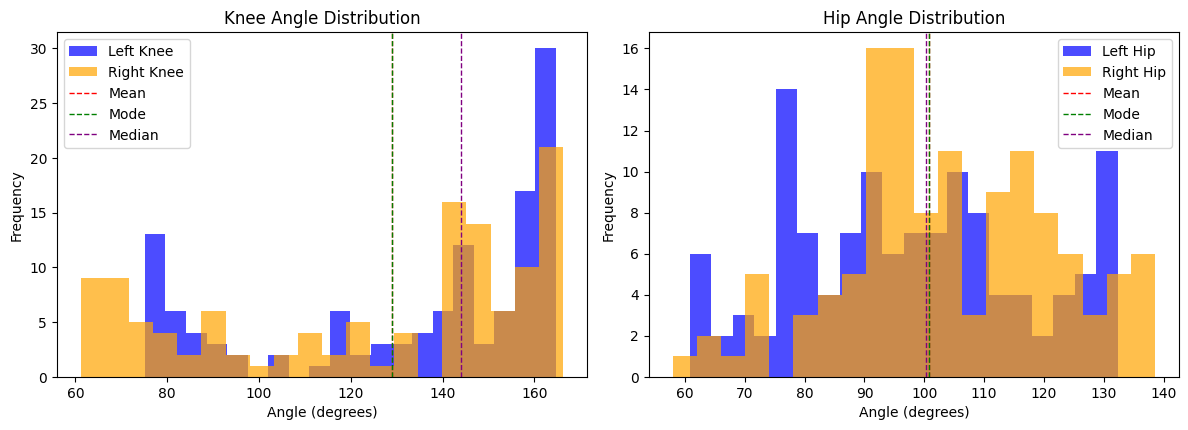

In [13]:
import matplotlib.pyplot as plt

# 히스토그램 시각화를 위한 데이터
left_knee_angles = angle_data['left_knee_angle']
right_knee_angles = angle_data['right_knee_angle']
left_hip_angles = angle_data['left_hip_angle']
right_hip_angles = angle_data['right_hip_angle']

# 히스토그램 그리기
plt.figure(figsize=(12, 8))

# 무릎 각도 히스토그램
plt.subplot(2, 2, 1)
plt.hist(left_knee_angles, bins=20, alpha=0.7, label='Left Knee', color='blue')
plt.hist(right_knee_angles, bins=20, alpha=0.7, label='Right Knee', color='orange')
plt.axvline(knee_mean_angle1, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(knee_mean_angle2.mean(), color='green', linestyle='dashed', linewidth=1, label='Mode')
plt.axvline(knee_mean_angle3, color='purple', linestyle='dashed', linewidth=1, label='Median')
plt.title('Knee Angle Distribution')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.legend()

# 엉덩이 각도 히스토그램
plt.subplot(2, 2, 2)
plt.hist(left_hip_angles, bins=20, alpha=0.7, label='Left Hip', color='blue')
plt.hist(right_hip_angles, bins=20, alpha=0.7, label='Right Hip', color='orange')
plt.axvline(hip_mean_angle1, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(hip_mean_angle2.mean(), color='green', linestyle='dashed', linewidth=1, label='Mode')
plt.axvline(hip_mean_angle3, color='purple', linestyle='dashed', linewidth=1, label='Median')
plt.title('Hip Angle Distribution')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.legend()

# 레이아웃 조정
plt.tight_layout()
plt.show()


### 평균 각도값 + 웹캠 + 카운트(간단하게)

In [16]:
import cv2
import mediapipe as mp
import pandas as pd
import glob
from class_code import make_angle

# 여러 CSV 파일 읽기
file_pattern = "lunge_csv_data/lunge_*.csv"
files = glob.glob(file_pattern)
all_data = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

# 관절 ID 매핑
LEFT_HIP = 23
LEFT_KNEE = 25
LEFT_ANKLE = 27
RIGHT_HIP = 24
RIGHT_KNEE = 26
RIGHT_ANKLE = 28

# 프레임별로 각도 계산
angles = []
for frame_number in all_data['frame'].unique():
    frame_data = all_data[all_data['frame'] == frame_number]

    try:
        # 왼쪽 관절 좌표
        left_hip = frame_data[frame_data['node_id'] == LEFT_HIP][['x', 'y', 'z']].values[0]
        left_knee = frame_data[frame_data['node_id'] == LEFT_KNEE][['x', 'y', 'z']].values[0]
        left_ankle = frame_data[frame_data['node_id'] == LEFT_ANKLE][['x', 'y', 'z']].values[0]

        # 오른쪽 관절 좌표
        right_hip = frame_data[frame_data['node_id'] == RIGHT_HIP][['x', 'y', 'z']].values[0]
        right_knee = frame_data[frame_data['node_id'] == RIGHT_KNEE][['x', 'y', 'z']].values[0]
        right_ankle = frame_data[frame_data['node_id'] == RIGHT_ANKLE][['x', 'y', 'z']].values[0]

        # 각도 계산
        left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
        right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)

        left_hip_angle = calculate_angle(left_knee, left_hip, right_hip)
        right_hip_angle = calculate_angle(right_knee, right_hip, left_hip)

        # 각도 저장
        angles.append({
            'frame': frame_number,
            'left_knee_angle': left_knee_angle,
            'right_knee_angle': right_knee_angle,
            'left_hip_angle': left_hip_angle,
            'right_hip_angle': right_hip_angle
        })

    except Exception as e:
        print(f"Frame {frame_number}: 오류 발생 - {e}")

# 결과를 DataFrame으로 변환
angle_data = pd.DataFrame(angles)


# 평균 각도 계산
knee_mean_angle = (angle_data['left_knee_angle'].mean() + angle_data['right_knee_angle'].mean()) / 2
hip_mean_angle = (angle_data['left_hip_angle'].mean() + angle_data['right_hip_angle'].mean()) / 2

print(knee_mean_angle)
print(hip_mean_angle)

KNEE_MIN, KNEE_MAX = knee_mean_angle - 40, knee_mean_angle + 10 
HIP_MIN, HIP_MAX = hip_mean_angle - 10, hip_mean_angle + 10

# 결과 출력
print(f"무릎 기준 각도: {int(KNEE_MIN)}° ~ {int(KNEE_MAX)}°")
print(f"엉덩이 기준 각도: {int(HIP_MIN)}° ~ {int(HIP_MAX)}°")

### 웹캠 포즈 설정
# Mediapipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# 카운터와 상태 변수 초기화
counter = 0
stage = "down"

# 웹캠 열기
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        
        def get_point(landmark):
            return [landmarks[landmark].x, landmarks[landmark].y, landmarks[landmark].z]
        
        # 왼쪽 관절
        left_hip = get_point(mp_pose.PoseLandmark.LEFT_HIP)
        left_knee = get_point(mp_pose.PoseLandmark.LEFT_KNEE)
        left_ankle = get_point(mp_pose.PoseLandmark.LEFT_ANKLE)
        
        # 오른쪽 관절
        right_hip = get_point(mp_pose.PoseLandmark.RIGHT_HIP)
        right_knee = get_point(mp_pose.PoseLandmark.RIGHT_KNEE)
        right_ankle = get_point(mp_pose.PoseLandmark.RIGHT_ANKLE)
        
        # 각도 계산
        left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
        right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)
        left_hip_angle = calculate_angle(left_knee, left_hip, right_hip)
        right_hip_angle = calculate_angle(right_knee, right_hip, left_hip)
        
        # 피드백
        feedback = []
        if not (KNEE_MIN <= left_knee_angle <= KNEE_MAX):
            feedback.append("Left knee angle : Wrong")
        else :
            feedback.append("Left knee angle : Correct")

        if not (KNEE_MIN <= right_knee_angle <= KNEE_MAX):
            feedback.append("Right knee angle : Wrong")
        else :
            feedback.append("Right knee angle : Correct")

        # if not (HIP_MIN <= left_hip_angle <= HIP_MAX):
        #     feedback.append("Left hip angle : Wrong")
        # else :
        #     feedback.append("Left hip angle : Correct")

        # if not (HIP_MIN <= right_hip_angle <= HIP_MAX):
        #     feedback.append("Right hip angle : Wrong")
        # else :
        #     feedback.append("Right hip angle : Correct")

        # 좌우 균형 비교
        knee_diff = abs(left_knee_angle - right_knee_angle)
        hip_diff = abs(left_hip_angle - right_hip_angle)
        
        if knee_diff > 10:
            feedback.append(f"Knee imbalance (difference: {int(knee_diff)})")
        else:
            feedback.append("Left and right knees are balanced")

        if hip_diff > 10:
            feedback.append(f"Hip imbalance (difference: {int(hip_diff)})")
        else:
            feedback.append("Left and right hips are balanced")

        # 피드백 텍스트: 줄바꿈(\n)으로 연결
        feedback_text = "\n".join(feedback) if feedback else "Correct"

        # 텍스트 출력: 왼쪽 상단에 표시
        y_offset = 20  # y축 시작 위치
        for i, line in enumerate(feedback_text.split("\n")):
            # 'correct' 포함 여부에 따라 색상 설정
                color = (0, 255, 0) if "Correct" in line or "balanced" in line else (0, 0, 255)
                cv2.putText(image, line, (10, y_offset + i * 20),  # 10: x축 위치, y_offset + i*20: 줄 간격
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                
        # 각도 정보도 화면에 출력
        cv2.putText(image, f"Left Knee: {int(left_knee_angle)}", (10, y_offset + 120),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        cv2.putText(image, f"Right Knee: {int(right_knee_angle)}", (10, y_offset + 140),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        cv2.putText(image, f"Left Hip: {int(left_hip_angle)}", (10, y_offset + 160),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        cv2.putText(image, f"Right Hip: {int(right_hip_angle)}", (10, y_offset + 180),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # 무릎 각도가 180도에 근접하면 'up' 상태로 변경하고 카운트 증가
        if left_knee_angle > KNEE_MAX and right_knee_angle > KNEE_MAX:
            if stage == "down":
                stage = "up"
                counter += 1
        elif left_knee_angle < KNEE_MAX and right_knee_angle < KNEE_MAX:
            stage = "down"

        # 카운터와 상태 출력
        h, w, _ = image.shape  # 이미지 높이와 너비 가져오기
        cv2.putText(image, f"Reps: {counter}", (w - 200, h - 50),  # 오른쪽 하단 위치
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
        # Mediapipe 관절 시각화
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    cv2.imshow("Lunge Analysis", image)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


128.99127109802743
100.77110987913241
무릎 기준 각도: 88° ~ 138°
엉덩이 기준 각도: 90° ~ 110°
